# Practica 3 (Regresión logística multiclase y redes neuronales)
### Aprendizaje automático y big data
##### _Alberto García Doménech - Pablo Daurell Marina_    
---

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Parte 1 (Regresión logística multiclase)

### Carga y visualización:
Vamos a intentar clasificar un conjunto de imagenes que representan números del  0 al 9 escritos a mano, para ello vamos a usar la regresión logística multiclase.

In [49]:
# cargamos los datos, en este caso 5000 ejemplos de entrenamiento(imagenes 20x20 pixeles)
from scipy.io import loadmat
data = loadmat ('ex3data1.mat')

# se pueden consultar las claves con data.keys()
y = data['y']
X = data['X']

np.shape(X) # (5000, 400)
np.shape(y) # (5000,1)

y = y.T[0]
np.shape(y) # (5000,)

num_examples = np.shape(X)[0] # 5000 ejemplos
num_features = np.shape(X)[1] # 400 atributos (por cada ejemplo)
num_etiquetas = 10 # Del 0 al 9

# añadimos una columna de 1's a la X
X = np.hstack([np.ones([num_examples, 1]), X])

Vemos una muestra de los ejemplos de nuestro conjunto de imágenes:

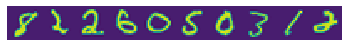

In [50]:
# seleccionamos 10 numeros al azar y los mostramos
sample = np.random.choice(X.shape[0], 10)
plt.imshow(X[sample, 1:].reshape(-1,20).T)
plt.axis('off')
plt.show()

### Optimización:
Vamos a usar regresión logística, por tanto podemos usar los métodos ```sigmoid```, ```cost``` y ```gradient``` creados en la práctica anterior:

In [51]:
# utilizamos de nuevo las funciones de coste,sigmoide y de gradiente
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def cost(Theta, X, Y, Lambda):
    H = sigmoid(np.matmul(X, Theta))
    aux = (-1 / len(X)) * ( np.matmul(np.log(H).T, Y) + np.matmul(np.log(1-H).T, (1-Y)))
    regul = (Lambda/(2*len(X))) * np.sum(Theta**2)
    return (aux + regul)

def gradient(Theta, X, Y, Lambda):
    H = sigmoid(np.matmul(X, Theta))
    aux = np.matmul(X.T, H - Y) / len(X)
    regul = (Lambda/len(X)) * Theta
    return (aux + regul)

En la práctica anterior usabamos la regresión logística para clasificar ejemplos entre dos clases, en este caso tenemos más de dos clases, concretamente 10 clases (números del 0 al 9), por tanto tenemos un problema de clasificación multiclase.   
Vamos a usar el método de OneVsAll mediante el cuál crearemos un clasificador distinito para cada clase. Cada clasificador se encargará de decidir si un ejemplo pertenece a la clase de ese clasificador o a alguna de las otras.   
La función ```oneVsAll``` devolverá una matriz de tamaño 10x401, es decir cada fila representará un clasificador que tendrá 401 atributos (400 ejemplos de nuestro conjunto de datos + 1 fila de unos)

In [52]:
import scipy.optimize as opt
def oneVsAll(X, y, num_etiquetas, reg):
    """
    oneVsAll entrena varios clasificadores por regresión logística con término
    de regularización 'reg' y devuelve el resultado en una matriz, donde la 
    fila i-ésima corresponde al clasificador de la etiqueta i-ésima
    """
    # Creamos una matriz de 'num_etiquetas' clasificadores con 'num_features + 1' atributos cada uno
    classifiers = np.zeros(shape=(num_etiquetas, num_features + 1))
    
    # entrenamos un clasificador por cada una de las clases del conjunto de datos
    for i in range(num_etiquetas):
        # Necesitamos un valor de theta por cada atributo
        theta = np.zeros(num_features + 1)
        
        # Dividimos nuestras clases en dos conjuntos, la clase que queremos predecir (y == i) y el resto (y != i)
        if i == 0:
            label = (y == 10) * 1
        else:
            label = (y == i) * 1
        
        # Entrenamos al clasificador
        result = opt.fmin_tnc(func=cost, x0=theta, fprime=gradient, args=(X, label, reg))
        classifiers[i, :] = result[0]
        
    return classifiers

### Clasificación:
Establecemos un valor de regularización de 0.1 y entrenamos a todos los clasificadores:

In [53]:
regul_param = 0.1
classifiers = oneVsAll(X, y, num_etiquetas, regul_param)

Una vez entrenados los clasificadores vamos a intentar predecir a que calses pertenecen los ejemplos.   
Calculamos $h_\theta(X)$ que nos devolverá la probabilidad que tiene cada ejemplo de pertenecer a cada clase.   
Finalmente, asignamos a cada ejemplo la clase para la que tenga una probabilidad más alta.

In [54]:
# Almacenamos en una matriz de 5000x9 las probabilidades de que cada ejemplo pertenezca a una clase
probabilities = sigmoid(np.matmul(X, classifiers.T))
# Nos quedamos con el indice (la clase) que tenga la probabilidad más alta
predictions = np.argmax(probabilities, axis=1)
np.place(predictions, predictions == 0, 10)

In [55]:
fallos =  np.where([predictions != y])[1]
print('Numero de fallos:', len(fallos))

aciertos = np.where([predictions == y])[1]
print('Numero de aciertos:', len(aciertos))

Numero de fallos: 175
Numero de aciertos: 4825


In [56]:
accuracy = 100 * np.mean(predictions == y)
print("Porcentaje de aciertos: ", accuracy)

Porcentaje de aciertos:  96.5


> Comparando las predicciones de nuestros clasificadores con los datos reales, vemos que hemos obtenido una **precisión del 96.5%**   

- A continuación vemos ejemplos de casos en los que hemos acertado y casos en los que hemos fallado:

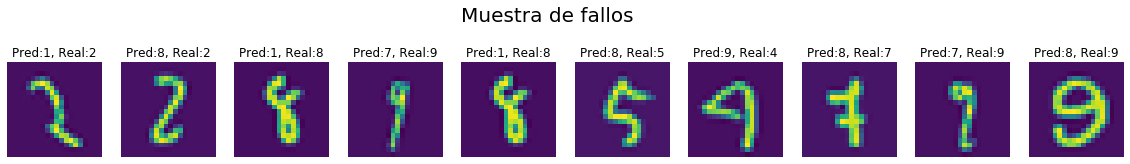

In [57]:
sample = fallos[np.random.choice(fallos.shape[0], 10)]

fig, axs = plt.subplots(1, 10, figsize=(20, 3), sharey=True)
fig.suptitle('Muestra de fallos', size=20)
i = 0
for fallo in sample:
    axs[i].imshow(X[fallo, 1:].reshape(-1,20).T)
    axs[i].axis('off')
    axs[i].set_title('Pred:{}, Real:{}'.format(predictions[fallo], y[fallo]))
    i = i + 1

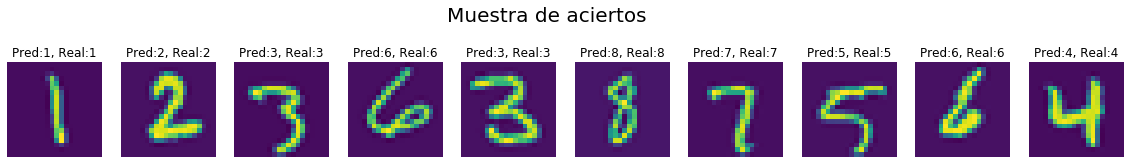

In [58]:
sample = aciertos[np.random.choice(aciertos.shape[0], 10)]

fig, axs = plt.subplots(1, 10, figsize=(20, 3), sharey=True)
fig.suptitle('Muestra de aciertos', size=20)
i = 0
for acierto in sample:
    axs[i].imshow(X[acierto, 1:].reshape(-1,20).T)
    axs[i].axis('off')
    axs[i].set_title('Pred:{}, Real:{}'.format(predictions[acierto], y[acierto]))
    i = i + 1

- Finalmente podemos ver la precisión de nuestros clasificadores en una matriz de confusión:

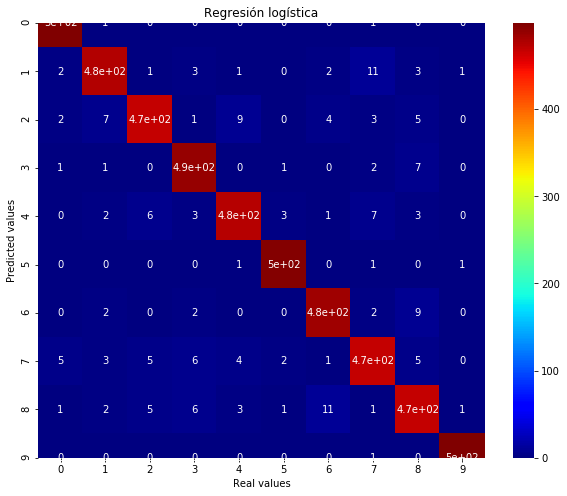

In [59]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y, predictions)
plt.figure(figsize=(10,8))
ax = sns.heatmap(cm, annot=True, cmap='jet')
ax.set(xlabel='Real values', ylabel='Predicted values', title='Regresión logística')
plt.show()

## Parte 2 (Redes neuronales)

Ahora vamos a intentar clasificar el mismo conjunto de datos pero esta vez haciendo uso de una red neuronal ya entrenada, por tanto solo necesitamos aplicar la propagación hacia delante a nuestros datos junto con los pesos ya calculados para poder hacer predicciones.

In [60]:
weights = loadmat('ex3weights.mat')
theta1, theta2 = weights['Theta1'], weights['Theta2']
# Theta1 es de dimensión 25 x 401
# Theta2 es de dimensión 10 x 26

Implementamos la propagación hacia delante necesaria para aplicar los pesos de la red neuronal a nuestros datos y poder hacer predicciones.   
Para ello necesitamos estos calculos:  
$z^{(2)} = \Theta^{(1)}x$   
$a^{(2)} = sigmoid(z^{(2)})$    
$z^{(3)} = \Theta^{(2)}a^{(2)}$      
$h_\Theta(x) = a^{(3)} = sigmoid(z^{(3)})$   

In [61]:
def forward_propagation(X, theta1, theta2):
    z_2 = np.dot(theta1, X.T)
    a_2 = sigmoid(z_2)
    a_2 = np.vstack([np.ones([1,a_2.shape[1]]),a_2]) # Añadimos fila con 1s para el término x0
    z_3 = np.dot(theta2, a_2)
    a_3 = sigmoid(z_3)
    return a_3

Aplicamos la propagación a nuestros ejemplos para poder predecir:

In [62]:
neural_net = forward_propagation(X, theta1, theta2)

In [63]:
predictions = np.argmax(neural_net, axis=0)+1

In [64]:
fallos =  np.where([predictions != y])[1]
print('Numero de fallos:', len(fallos))

aciertos = np.where([predictions == y])[1]
print('Numero de aciertos:', len(aciertos))

Numero de fallos: 124
Numero de aciertos: 4876


In [65]:
accuracy = 100 * np.mean(predictions == y)
print("Porcentaje de aciertos: ", accuracy)

Porcentaje de aciertos:  97.52


> Esta vez, comparando las predicciones con los datos reales obtenemos una **precisión del 97%**

- Podemos ver la precisión en una matriz de confusión:

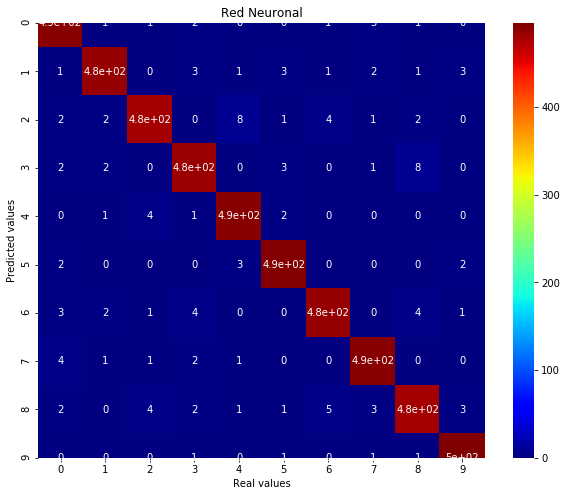

In [66]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y, predictions)
plt.figure(figsize=(10,8))
ax = sns.heatmap(cm, annot=True, cmap='jet')
ax.set(xlabel='Real values', ylabel='Predicted values', title='Red Neuronal')
plt.show()